<a href="https://colab.research.google.com/github/acevedo-s/Machine-learning-phases-of-matter/blob/master/triangular_dense_correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
import time
from google.colab import drive  
drive.mount('/content/drive')

import keras
keras.__version__
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.utils import to_categorical  
from keras.regularizers import l2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


In [ ]:
def loadD(name,datapath,labelflag,Tc,a,trainflag):
  print(name) #name just for reference
  data=[]
  with open(datapath, newline='\n') as csvfile: #read data file
    csv_reader = csv.reader(csvfile, delimiter=' ')
    for line in csv_reader:
      line.remove('') #remove this white space
      if (labelflag==0): #if not labeled, i label it.
          if (float(line[0])<Tc):
            line.insert(0,0)
          else:
            line.insert(0,1)
      data.append(line)

  if (trainflag):
    window=[] # i remove a window from data with T close to Tc
    for x in data[:]:
      if (abs(Tc-float(x[1]))<a): # T=data[k][1]
        window.append(x)
        data.remove(x)
  #now data only has data far from Tc
  r=0.75 ; l=int(r*len(data))
  train_data=data[:l]  #i partition here the hole data set between train data and test data.
  random.shuffle(train_data)
  test_data=data[l:len(data)]
  if (trainflag):
    test_data=test_data+window
  del(data)

  train_labels,train_temperatures,train_data=get_format(train_data) #(validation data will be a fraction of the train data)
  test_labels,test_temperatures,test_data=get_format(test_data)

  print('lenght of train data: ', len(train_data))
  print('lenght of test data: ', len(test_data))

  checkflag=1
  if trainflag:
    if checkflag:
      c=0
      for T in train_temperatures: # to see if some forbidden temperature is still in the training set.
        if(abs(T-Tc)<a):
          c+=1
      print('checkflag:',c)
  return [train_data,train_labels,test_data,test_labels,test_temperatures]
###################-----------------
def get_format(data):
  labels=[]
  temperatures=[]
  for element in data:
    label=element.pop(0) # remove the first element, the label
    labels.append(label) # add to label list
    TT=element.pop(0)  # remove the second element, the temperature
    temperatures.append(TT) # add to temperature list
  #numpy arrays of strings, and string to integers
  data=np.array(data)
  data = data.astype(np.float)
  #data=(data+1.)/2 # normalization later !!! 
  labels=np.array(labels)
  labels=labels.astype(np.int)
  temperatures=np.array(temperatures)
  temperatures=temperatures.astype(np.float)
  return labels,temperatures,data
#######################---------------------------

def ProbabilityPredictions(model,test_data,test_temperatures):
  test_predictions=model.predict(test_data)
  prob_T=[]
  for j in range(len(test_temperatures)):
    prob_T.append([test_temperatures[j],test_predictions[j]])
  #print(prob_T[0])
  prob_T=sorted(prob_T,key=lambda x: x[0]) # ordered by temperatures
  len(prob_T)

  #prob_TNP=np.array([])
  j=0
  epsilon=0.001
  j_max=len(prob_T)

  while(j+1 < j_max-1): # for the same temperatures i average the results
    count=1
    while(j+1 < j_max and abs(prob_T[j][0]-prob_T[j+1][0])<epsilon):
      count=count+1
      x=prob_T.pop(j+1)
      prob_T[j][1]=prob_T[j][1]+x[1]
      j_max=len(prob_T)
    prob_T[j][1]=prob_T[j][1]/float(count)
    j=j+1
    j_max=len(prob_T)
  
  print('number of temperatures: ',len(prob_T))
  T_list=[];p1_list=[];p2_list=[];check_list=[]
  for j in range(len(prob_T)):
    T_list.append(prob_T[j][0])
    p1_list.append(prob_T[j][1][0])
    p2_list.append(prob_T[j][1][1])
    #check_list.append(prob_T[j][1][1] +prob_T[j][1][0] )
  return [T_list,p1_list,p2_list]

########################----------
########################----------------------------------------

#for fancy plotting
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'figure.autolayout': True})


In [ ]:
def spin2corr(data,L):
  Nruns=np.shape(data)[0]
  corrd=np.zeros((Nruns,L*L))
  i0=j0=int(L/2) # center spin as reference 
  for n in range(Nruns):
    for i in range(L):
      for j in range(L):  
        corrd[n][L*i+j]=data[n][L*i+j]*data[n][L*i0+j0]
  return corrd

In [ ]:
def makedicy(name,L,path,label,Tc,loadflag,categoricalflag):
  mydict={'name': name,'L':L,'path':path,'label':label,'Tc':Tc\
          ,'loadflag':loadflag,'categoricalflag':categoricalflag}
  return mydict

Dicyslist=[];
L=30
Nfiles=0
k=0
# #honeycombe lattice 
# name='honeycombeNN'
# path='drive/My Drive/Machine Learning magnetism/paper2020/data_honey_AF/900/arrays_30_-0.00.txt'
# x=makedicy(name,L,path,0,1.519,1,1)
# Dicyslist.append([x])
# Nfiles+=1

# #honeycombe lattice with correlations 
# name='HoneycombeNN - correlations '
# path=' '
# x=makedicy(name,L,path,0,1.519,0,1)
# Dicyslist.append([x])
# Nfiles+=1

# #square lattice 
# name='squaredNN'
# path='drive/My Drive/Machine Learning magnetism/paper2020/data_squared_AF/30x30/square_AF0.0.txt'
# x=makedicy(name,L,path,0,2.2691,1,1)
# Dicyslist.append([x])
# Nfiles+=1

# #square lattice with correlations 
# name='squaredNN - correlations '
# path=' '
# x=makedicy(name,L,path,0,2.2691,0,1)
# Dicyslist.append([x])
# Nfiles+=1

#triangular lattice
name='TriangularNN'
path='drive/My Drive/Machine Learning magnetism/paper2020/data_triang_30/triang_AF_30.txt'
x=makedicy(name,L,path,1,1.2,1,1)
Dicyslist.append(x)
Nfiles+=1

#triangular lattice with correlations 
name='TriangularNN - correlations '
path=' '
x=makedicy(name,L,path,1,1.2,0,1)
Dicyslist.append(x)
Nfiles+=1

for k in range(Nfiles):
  Dicyslist[k]['normalizationflag']=1 #not normalized data, we will normalize it later. 

print('Nfiles=',Nfiles)

Nfiles= 2


In [ ]:
#adding data to diccionary  
#'data' format is as follows: 
# train_data,train_labels,test_data,test_labels,test_temperatures
a=0.3 # parameter to exclude transition data from training
trainflag=1
for k in range(Nfiles): # this takes a while
  if (Dicyslist[k]['loadflag']):
    start_time = time.time()
    Dicyslist[k]['data']=loadD(Dicyslist[k]['name'],Dicyslist[k]['path'] \
                            ,Dicyslist[k]['label'],Dicyslist[k]['Tc'],a,trainflag)
    Dicyslist[k]['loadflag']=0 #lo lei, entonces cambio el flag para no volver a leerlo.
    elapsed_time = time.time() - start_time
    print('this took ',round(elapsed_time,2),' seconds')


##########
for k in range(0,Nfiles,2):
  start_time = time.time()
  corrtrain=spin2corr(Dicyslist[k]['data'][0],L) # train data to correlations  # this takes a whiileee
  corrtest=spin2corr(Dicyslist[k]['data'][2],L) # test data to correlations
  Dicyslist[k+1]['data']=[]
  Dicyslist[k+1]['data'].append(corrtrain) # transformed train data 
  Dicyslist[k+1]['data'].append(Dicyslist[k]['data'][1]) #same train labels
  Dicyslist[k+1]['data'].append(corrtest) # transformed test data 
  Dicyslist[k+1]['data'].append(Dicyslist[k]['data'][3]) #same train labels
  Dicyslist[k+1]['data'].append(Dicyslist[k]['data'][4]) #same test temperatures
  elapsed_time = time.time() - start_time
  print(' ')
  print('lenght of train data check (correlations)', len(Dicyslist[k+1]['data'][0]))
  print('lenght of test data check (correlations) ', len(Dicyslist[k+1]['data'][2]))
  print('this took ',round(elapsed_time,2),' seconds')


TriangularNN
lenght of train data:  51900
lenght of test data:  28100
checkflag: 0
this took  121.27  seconds
 
lenght of train data check (correlations) 51900
lenght of test data check (correlations)  28100
this took  84.32  seconds


In [ ]:
n=5
print(Dicyslist[0]['data'][0][n][0:15])
print(Dicyslist[1]['data'][0][n][0:15])

[-1. -1.  1.  1.  1. -1. -1. -1.  1.  1.  1. -1. -1.  1. -1.]
[ 1.  1. -1. -1. -1.  1.  1.  1. -1. -1. -1.  1.  1. -1.  1.]


###Training

In [ ]:
# Keras formatting
for k in range(Nfiles): 
  if (Dicyslist[k]['normalizationflag']):
    Dicyslist[k]['data'][0]=(Dicyslist[k]['data'][0]+1.)/2 # normalization
    Dicyslist[k]['data'][2]=(Dicyslist[k]['data'][2]+1.)/2 # normalization
    Dicyslist[k]['normalizationflag']=0 #now normalized data. 
  if (Dicyslist[k]['categoricalflag']):
    Dicyslist[k]['data'][1] = to_categorical(Dicyslist[k]['data'][1])
    Dicyslist[k]['data'][3] = to_categorical(Dicyslist[k]['data'][3])
    Dicyslist[k]['categoricalflag']=0; # because this must be done only one time.


In [ ]:
def train(Dicyslist,k,epochs_val,l2reg):
  L=Dicyslist[k]['L']
  damn=optimizers.Adam(lr=0.0005,beta_1=0.9, beta_2=0.999, amsgrad=False)
  model = models.Sequential()
  Ndense=32# number of neurons in the dense hidden layer
  model.add(layers.Dense(Ndense, activation='sigmoid',activity_regularizer=l2(l2reg)))
  model.add(layers.Dense(2, activation='softmax'))
  Bsize=128 #
  VS=0.1 #validation split
  #optimizer='rmsprop'
  #metrics=[keras_metrics.precision(), keras_metrics.recall()]
  #metrics=['accuracy']
  model.compile(optimizer=damn,
  loss='categorical_crossentropy',
  metrics=['accuracy'])#,keras.metrics.Precision(), keras.metrics.Recall()] )
  history=model.fit(Dicyslist[k]['data'][0], Dicyslist[k]['data'][1], validation_split=VS,
            shuffle=True, epochs=epochs_val, batch_size=Bsize)
  # train_data,train_labels,test_data,test_labels,test_temperatures
  history_dict = history.history
  return model, history_dict

In [ ]:
eN=16 # number of epochs 
eplist=[eN,eN]
l2reg=0.00005

def acctrain(Nfiles,Dicyslist,eplist,l2reg):
  acclist=[];modellist=[];historylist=[]
  for k in range(Nfiles):
    epochs_val=eplist[k]
    print(Dicyslist[k]['name'])
    model,history=train(Dicyslist,k,epochs_val,l2reg)
    modellist.append(model)
    historylist.append(history)
    test_loss, test_acc = model.evaluate(Dicyslist[k]['data'][2], Dicyslist[k]['data'][3])
    print('acc on test data: ',test_acc)
    acclist.append(test_acc)
  return acclist[0],acclist[1],modellist
def getprobpredictions(modellist,Dicyslist,Nfiles):
  p1_list=[];
  p2_list=[];
  for k in range (Nfiles):
    T_list,x,y=ProbabilityPredictions(modellist[k],Dicyslist[k]['data'][2],Dicyslist[k]['data'][4])
    p1_list.append(x)
    p2_list.append(y)
  p1_list=np.array(p1_list)
  p2_list=np.array(p2_list)
  return p1_list,p2_list,T_list

accspin=acccorr=0
p1prom=p2prom=0
Nprom=6 # i will take the average over a few trainings. 
for n in range(Nprom):
  accs,accc,modellist=acctrain(Nfiles,Dicyslist,eplist,l2reg)
  accspin+=accs/Nprom
  acccorr+=accc/Nprom
  p1_list,p2_list,T_list=getprobpredictions(modellist,Dicyslist,Nfiles)
  p1prom+=p1_list/Nprom
  p2prom+=p2prom/Nprom



TriangularNN
Train on 46710 samples, validate on 5190 samples
Epoch 1/16
46710/46710 [==============================] - 1s 24us/step - loss: 0.4827 - accuracy: 0.7984 - val_loss: 0.3339 - val_accuracy: 0.8852
Epoch 2/16
46710/46710 [==============================] - 1s 22us/step - loss: 0.2498 - accuracy: 0.9442 - val_loss: 0.1872 - val_accuracy: 0.9684
Epoch 3/16
46710/46710 [==============================] - 1s 22us/step - loss: 0.1641 - accuracy: 0.9711 - val_loss: 0.1414 - val_accuracy: 0.9757
Epoch 4/16
46710/46710 [==============================] - 1s 22us/step - loss: 0.1351 - accuracy: 0.9748 - val_loss: 0.1238 - val_accuracy: 0.9761
Epoch 5/16
46710/46710 [==============================] - 1s 22us/step - loss: 0.1215 - accuracy: 0.9763 - val_loss: 0.1161 - val_accuracy: 0.9759
Epoch 6/16
46710/46710 [==============================] - 1s 22us/step - loss: 0.1128 - accuracy: 0.9773 - val_loss: 0.1123 - val_accuracy: 0.9751
Epoch 7/16
46710/46710 [==============================] 

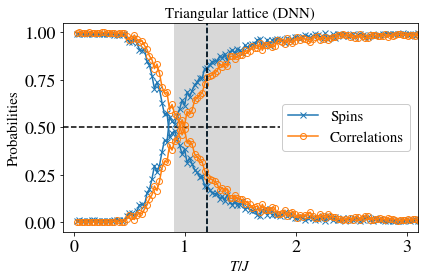

spin accuracy:  0.8406287133693694 
correlation accuracy:  0.8474673827489216


In [ ]:
###predictions:
from google.colab import files
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
markers=['x','o']
llist=['Spins','Correlations']
file_name="corr_dense_triang.pdf"
for k in range(0,Nfiles,2):
  fig = plt.figure() 
  ax = fig.add_subplot(111)  
  ll=llist[k%2]
  plt.plot(T_list, p1_list[k], label=ll,marker=markers[k],color=colors[k])#,mfc='none') #
  plt.plot(T_list, p2_list[k],marker=markers[k],color=colors[k])#,mfc='none')#, label='')
  ll=llist[(k+1)%2]
  plt.plot(T_list, p1_list[k+1], label=ll,marker=markers[k+1],color=colors[k+1],mfc='none') #
  plt.plot(T_list, p2_list[k+1],marker=markers[k+1],color=colors[k+1],mfc='none')#, label='')
  Tc=Dicyslist[k]['Tc']

  plt.axvline(x=Tc,color=colors[k],linestyle='--')
  plt.title('Triangular lattice (DNN)',size = 15)
  plt.xlabel(r'$T/J$',size = 15)
  plt.ylabel('Probabilities',size = 15)
  plt.legend(loc='best',prop={'size': 15},framealpha=1)
  plt.axvline(x=Tc,color='black',linestyle='--')
  g1=Tc-a ; g2=Tc+a
  plt.axvspan(g1, g2, color='gray', alpha=0.3, lw=0) # shaded gray
  xmaxx=3.1
  plt.hlines(y=0.5,xmin=-0.1,xmax=0.6*xmaxx,color='black',linestyle='--')
  ax.set_xlim(-0.1,xmaxx)
  plt.savefig(file_name)
  plt.show()
print('spin accuracy: ',accspin,'\ncorrelation accuracy: ',acccorr)

In [ ]:
  files.download(file_name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(modellist[0].summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 32)                28832     
_________________________________________________________________
dense_56 (Dense)             (None, 2)                 66        
Total params: 28,898
Trainable params: 28,898
Non-trainable params: 0
_________________________________________________________________
None
